이 데이터를 가지고 평가하고 몇 가지 분류기를 사용해서 진행 

수도코드를 짜서 간단한 plan을 작성

single major function --> 심플하고 단순하게 다양하게 저용

큰 구조를 작성하고 자동으로 작동하게 끔 진행

PHW1은 다음 주까지 진행 

1.   데이터 load
2.   데이터 cleanging

결측값 확인 --> Bare Nuclei 확인 결과 ?로 결측값 존재

data에 

Sample code number은 불필요하다고 판단해서 제거


3.   데이터 scaling




In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

warnings.filterwarnings(action='ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
df = pd.read_csv("dataset/breast-cancer-wisconsin.data",header=None)

In [30]:
df.columns = ['Sample code number','Clump Thickness ','Uniformity of Cell Size','Uniformity of Cell Shape','Marginal Adhesion','Single Epithelial Cell Size','Bare Nuclei','Bland Chromatin','Normal Nucleoli','Mitoses','Class']

In [31]:
df = df.replace('?', np.NaN)

In [32]:
df.isnull().sum()

Sample code number              0
Clump Thickness                 0
Uniformity of Cell Size         0
Uniformity of Cell Shape        0
Marginal Adhesion               0
Single Epithelial Cell Size     0
Bare Nuclei                    16
Bland Chromatin                 0
Normal Nucleoli                 0
Mitoses                         0
Class                           0
dtype: int64

In [33]:
df.fillna(0,inplace=True)

In [34]:
df.isnull().sum()

Sample code number             0
Clump Thickness                0
Uniformity of Cell Size        0
Uniformity of Cell Shape       0
Marginal Adhesion              0
Single Epithelial Cell Size    0
Bare Nuclei                    0
Bland Chromatin                0
Normal Nucleoli                0
Mitoses                        0
Class                          0
dtype: int64

In [35]:
df.drop('Sample code number', axis=1, inplace=True)

In [36]:
X, y = df.drop(['Class'], axis=1), df['Class']

In [37]:
#model, scaler, K parameter
models = ['DecisionTreeClassifier', 'LogisticRegression', 'svm.SVC']
scalers = [StandardScaler(), MinMaxScaler()]
Ks = [5, 10, 15]

# decision_tree_parameter
criterions = ['gini', 'entropy']
splitters = ['best', 'random']
max_depths = [1, 10, 100]

# logi_tree_parameter
solvers = ['lbfgs', 'sag']
max_iters = [50, 100, 200]

# svm_parameter
Cs = [0.1, 1]
gammas = [0.1, 0.3, 0.5, 1, 5]
kernels = ['rbf', 'sigmoid']
max_iters = [50, 100, 200]

# Dictionary parameter
dt_parameter = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [1, 10, 100]
}

lg_parameter = {
    'solver': ['lbfgs', 'sag'],
    'max_iter': [50, 100, 200]
}

svm_parameter = {
    'C': [0.1, 1],
    'gamma': [0.1, 0.3, 0.5, 1, 5],
    'kernel': ['rbf', 'sigmoid'],
    'max_iter': [50, 100, 200]
}

# make parameter list
total_parameter = [scalers, Ks, criterions, splitters, max_depths, solvers, max_iters, Cs, gammas, kernels, max_iters]

In [38]:
def create_model(X, y, models, params):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)
    accuracy = pd.DataFrame(columns=['model', 'scaler', 'K', 'parm', 'score'])

    for model in models:
        if model == 'DecisionTreeClassifier':
            DT_accuracy = DT_train_model(X_train, X_test, y_train, y_test, params[0], params[1], params[2], params[3],
                                         params[4])
            accuracy = pd.concat([accuracy, DT_accuracy])
            print("\n")
        elif model == 'LogisticRegression':
            LG_accuracy = LG_train_model(X_train, X_test, y_train, y_test, params[0], params[1], params[5], params[6])
            accuracy = pd.concat([accuracy, LG_accuracy])
            print("\n")

        elif model == 'svm.SVC':
            SVM_accuracy = SVM_train_model(X_train, X_test, y_train, y_test, params[0], params[1], params[7], params[8],
                                           params[9], params[10])
            accuracy = pd.concat([accuracy, SVM_accuracy])

            print("\n")
        else:
            print("Input model Error")

    return accuracy

In [39]:
def DT_train_model(X_train, X_test, y_train, y_test, scalers, Ks, criterions, splitters, max_depths):
    DT_accuracy = pd.DataFrame(columns=['model', 'scaler', 'K', 'parm', 'score'])

    print("========================")
    print("[DecisionTreeClassifier]")
    print("========================")

    for scaler in scalers:
        for criterion in criterions:
            for splitter in splitters:
                for max_depth in max_depths:
                    for K in Ks:
                        # do use Scaler
                        X_train = scaler.fit_transform(X_train)
                        X_test = scaler.fit_transform(X_test)

                        # build DecisionTreeClassifier model and fit data
                        DT = DecisionTreeClassifier(criterion=criterion, splitter=splitter, max_depth=max_depth,
                                                    random_state=42)

                        # do k-fold validation (cv=k)
                        score = cross_val_score(DT, X_train, y_train, cv=K)
                        score = np.mean(score)

                        print(
                            "DecisionTreeClassifier Average of scores : %f (scaler = %s, k = %s, criterion = %s, splitter = %s, max_depth = %s)" % (
                                score, scaler, K, criterion, splitter, max_depth))

                        data_to_insert = {'model': 'DecisionTreeClassifier', 'scaler': scaler, 'K': K,
                                          'parm': '{\'criterion\' : %s, \'splitter\' : %s, \'max_depth\' : %s}' % (
                                              criterion, splitter, max_depth), 'score': score}
                        DT_accuracy = DT_accuracy.append(data_to_insert, ignore_index=True)

    DT_accuracy = DT_accuracy.nlargest(5, 'score')
    return DT_accuracy

In [40]:
def LG_train_model(X_train, X_test, y_train, y_test, scalers, Ks, solvers, max_iters):
    LG_accuracy = pd.DataFrame(columns=['model', 'scaler', 'K', 'parm', 'score'])

    print("========================")
    print("[LogisticRegression]")
    print("========================")

    for scaler in scalers:
        for solver in solvers:
            for max_iter in max_iters:
                for K in Ks:
                    # do use Scaler
                    X_train = scaler.fit_transform(X_train)
                    X_test = scaler.fit_transform(X_test)

                    # build LogisticRegression model and fit data
                    LG = LogisticRegression(solver=solver, max_iter=max_iter, random_state=42)

                    # do k-fold validation (cv=k)
                    score = cross_val_score(LG, X_train, y_train, cv=K)
                    score = np.mean(score)

                    print(
                        "LogisticRegression Average of scores : %f (scaler = %s, k = %s, solver = %s, max_iter = %s)" % (
                            score, scaler, K, solver, max_iter))

                    data_to_insert = {'model': 'LogisticRegression', 'scaler': scaler, 'K': K,
                                      'parm': '{\'solver\' : %s, \'max_iter\' : %s}' % (solver, max_iter),
                                      'score': score}
                    LG_accuracy = LG_accuracy.append(data_to_insert, ignore_index=True)

    LG_accuracy = LG_accuracy.nlargest(5, 'score')
    return LG_accuracy

In [41]:
def SVM_train_model(X_train, X_test, y_train, y_test, scalers, Ks, Cs, gammas, kernels, max_iters):
    SVM_accuracy = pd.DataFrame(columns=['model', 'scaler', 'K', 'parm', 'score'])

    print("========================")
    print("[SVM]")
    print("========================")
    for scaler in scalers:
        for C in Cs:
            for gamma in gammas:
                for kernel in kernels:
                    for max_iter in max_iters:
                        for K in Ks:
                            # do use Scaler
                            X_train = scaler.fit_transform(X_train)
                            X_test = scaler.fit_transform(X_test)
                            # build SVM model and fit data
                            SVM = svm.SVC(C=C, gamma=gamma, kernel=kernel, max_iter=max_iter, random_state=42)

                            # do k-fold validation (cv=k)
                            score = cross_val_score(SVM, X_train, y_train, cv=K)

                            score = np.mean(score)

                            print(
                                "SVM Average of scores : %f (scaler = %s, k = %s, C = %s, gamma = %s, kernel = %s, max_iter = %s)" % (
                                    score, scaler, K, C, gamma, kernel, max_iter))
                            data_to_insert = {'model': 'SVM', 'scaler': scaler, 'K': K,
                                              'parm': '{\'C\' : %s, \'gamma\' : %s, \'kernel\' : %s, \'max_iter\' : %s}' % (
                                              C, gamma, kernel, max_iter), 'score': score}
                        SVM_accuracy = SVM_accuracy.append(data_to_insert, ignore_index=True)

    SVM_accuracy = SVM_accuracy.nlargest(5, 'score')
    return SVM_accuracy

In [42]:
accuracy = create_model(X, y, models, total_parameter)

[DecisionTreeClassifier]
DecisionTreeClassifier Average of scores : 0.894418 (scaler = StandardScaler(), k = 5, criterion = gini, splitter = best, max_depth = 1)
DecisionTreeClassifier Average of scores : 0.906948 (scaler = StandardScaler(), k = 10, criterion = gini, splitter = best, max_depth = 1)
DecisionTreeClassifier Average of scores : 0.901470 (scaler = StandardScaler(), k = 15, criterion = gini, splitter = best, max_depth = 1)
DecisionTreeClassifier Average of scores : 0.933752 (scaler = StandardScaler(), k = 5, criterion = gini, splitter = best, max_depth = 10)
DecisionTreeClassifier Average of scores : 0.944545 (scaler = StandardScaler(), k = 10, criterion = gini, splitter = best, max_depth = 10)
DecisionTreeClassifier Average of scores : 0.940920 (scaler = StandardScaler(), k = 15, criterion = gini, splitter = best, max_depth = 10)
DecisionTreeClassifier Average of scores : 0.933752 (scaler = StandardScaler(), k = 5, criterion = gini, splitter = best, max_depth = 100)
Decisio

In [43]:
# sort value by score by descending order
accuracy = accuracy.sort_values(by=['score'], ascending=False)

# reset index number and restore
accuracy = accuracy.reset_index(drop=True)

accuracy

,model,scaler,K,parm,score
0,SVM,StandardScaler(),15,"{'C' : 0.1, 'gamma' : 5, 'kernel' : sigmoid, 'max_iter' : 50}",0.973115
1,SVM,StandardScaler(),15,"{'C' : 0.1, 'gamma' : 5, 'kernel' : sigmoid, 'max_iter' : 100}",0.973115
2,SVM,StandardScaler(),15,"{'C' : 0.1, 'gamma' : 5, 'kernel' : sigmoid, 'max_iter' : 200}",0.973115
3,SVM,StandardScaler(),15,"{'C' : 0.1, 'gamma' : 0.3, 'kernel' : sigmoid, 'max_iter' : 50}",0.971361
4,SVM,MinMaxScaler(),15,"{'C' : 1, 'gamma' : 1, 'kernel' : rbf, 'max_iter' : 50}",0.971361
5,LogisticRegression,StandardScaler(),10,"{'solver' : lbfgs, 'max_iter' : 50}",0.964221
6,LogisticRegression,StandardScaler(),10,"{'solver' : lbfgs, 'max_iter' : 100}",0.964221
7,LogisticRegression,StandardScaler(),10,"{'solver' : lbfgs, 'max_iter' : 200}",0.964221
8,LogisticRegression,StandardScaler(),10,"{'solver' : sag, 'max_iter' : 50}",0.964221
9,LogisticRegression,StandardScaler(),10,"{'solver' : sag, 'max_iter' : 100}",0.964221


In [44]:
# checking model parameter
def check_model(X, y, models, scalers, Ks, dt_parameter, lg_parameter, svm_parameter):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)
    accuracy = pd.DataFrame(columns=['model', 'scaler', 'K', 'parm', 'score'])

    for model in models:
        if model == 'DecisionTreeClassifier':
            DT_accuracy = DT_grid_model(X_train, X_test, y_train, y_test, scalers, Ks, dt_parameter)
            accuracy = pd.concat([accuracy, DT_accuracy])
            print("\n")
        elif model == 'LogisticRegression':
            LG_accuracy = LG_grid_model(X_train, X_test, y_train, y_test, scalers, Ks, lg_parameter)
            accuracy = pd.concat([accuracy, LG_accuracy])
            print("\n")

        elif model == 'svm.SVC':
            SVM_accuracy = SVM_grid_model(X_train, X_test, y_train, y_test, scalers, Ks, svm_parameter)
            accuracy = pd.concat([accuracy, SVM_accuracy])

            print("\n")
        else:
            print("Input model Error")

    return accuracy

In [45]:
def DT_grid_model(X_train, X_test, y_train, y_test, scalers, Ks, dt_parameter):
    DT_accuracy = pd.DataFrame(columns=['model', 'scaler', 'K', 'parm', 'score'])

    print("==========================================")
    print("[DecisionTreeClassifier With GridSearchCV]")
    print("==========================================")

    for scaler in scalers:
        print("------------------------------------------")
        print("[%s]" % scaler)
        print("------------------------------------------")

        for K in Ks:
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.fit_transform(X_test)
            DT = DecisionTreeClassifier(random_state=42);
            grid_DT = GridSearchCV(DT, param_grid=dt_parameter, cv=K, scoring="accuracy")
            grid_DT.fit(X_train, y_train)

            print('GridSearchCV Best parameters (using k : %s) : ' % K, grid_DT.best_params_)
            print('GridSearchCV Best accuracy : %0.6f' % grid_DT.best_score_)

            data_to_insert = {'model': 'DecisionTreeClassifier', 'scaler': scaler, 'K': K,
                              'parm': grid_DT.best_params_, 'score': grid_DT.best_score_}
            DT_accuracy = DT_accuracy.append(data_to_insert, ignore_index=True)

    DT_accuracy = DT_accuracy.nlargest(1, 'score')
    return DT_accuracy


In [46]:
def LG_grid_model(X_train, X_test, y_train, y_test, scalers, Ks, lg_parameter):
    LG_accuracy = pd.DataFrame(columns=['model', 'scaler', 'K', 'parm', 'score'])

    print("==========================================")
    print("[LogisticRegression With GridSearchCV]")
    print("==========================================")

    for scaler in scalers:
        print("------------------------------------------")
        print("[%s]" % scaler)
        print("------------------------------------------")

        for K in Ks:
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.fit_transform(X_test)
            LG = LogisticRegression(random_state=42);
            grid_LG = GridSearchCV(LG, param_grid=lg_parameter, cv=K, scoring="accuracy")
            grid_LG.fit(X_train, y_train)

            print('GridSearchCV Best parameters (using k : %s) : ' % K, grid_LG.best_params_)
            print('GridSearchCV Best accuracy : %0.6f' % grid_LG.best_score_)

            data_to_insert = {'model': 'LogisticRegression', 'scaler': scaler, 'K': K,
                              'parm': grid_LG.best_params_, 'score': grid_LG.best_score_}
            LG_accuracy = LG_accuracy.append(data_to_insert, ignore_index=True)

    LG_accuracy = LG_accuracy.nlargest(1, 'score')
    return LG_accuracy

In [47]:
def SVM_grid_model(X_train, X_test, y_train, y_test, scalers, Ks, svm_parameter):
    SVM_accuracy = pd.DataFrame(columns=['model', 'scaler', 'K', 'parm', 'score'])

    print("==========================================")
    print("[SVM With GridSearchCV]")
    print("==========================================")

    for scaler in scalers:
        print("------------------------------------------")
        print("[%s]" % scaler)
        print("------------------------------------------")
        for K in Ks:
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.fit_transform(X_test)
            SVM = svm.SVC(random_state=42);
            grid_SVM = GridSearchCV(SVM, param_grid=svm_parameter, cv=K, scoring="accuracy")
            grid_SVM.fit(X_train, y_train)

            print('GridSearchCV Best parameters (using k : %s) : ' % K, grid_SVM.best_params_)
            print('GridSearchCV Best accuracy : %0.6f' % grid_SVM.best_score_)
            data_to_insert = {'model': 'SVM', 'scaler': scaler, 'K': K,
                              'parm': grid_SVM.best_params_, 'score': grid_SVM.best_score_}
            SVM_accuracy = SVM_accuracy.append(data_to_insert, ignore_index=True)

    SVM_accuracy = SVM_accuracy.nlargest(1, 'score')
    return SVM_accuracy

In [48]:
grid_accuracy = check_model(X, y, models, scalers, Ks, dt_parameter, lg_parameter, svm_parameter)

[DecisionTreeClassifier With GridSearchCV]
------------------------------------------
[StandardScaler()]
------------------------------------------
GridSearchCV Best parameters (using k : 5) :  {'criterion': 'entropy', 'max_depth': 10, 'splitter': 'best'}
GridSearchCV Best accuracy : 0.948069
GridSearchCV Best parameters (using k : 10) :  {'criterion': 'gini', 'max_depth': 10, 'splitter': 'best'}
GridSearchCV Best accuracy : 0.944545
GridSearchCV Best parameters (using k : 15) :  {'criterion': 'entropy', 'max_depth': 10, 'splitter': 'random'}
GridSearchCV Best accuracy : 0.948127
------------------------------------------
[MinMaxScaler()]
------------------------------------------
GridSearchCV Best parameters (using k : 5) :  {'criterion': 'entropy', 'max_depth': 10, 'splitter': 'best'}
GridSearchCV Best accuracy : 0.948069
GridSearchCV Best parameters (using k : 10) :  {'criterion': 'gini', 'max_depth': 10, 'splitter': 'best'}
GridSearchCV Best accuracy : 0.944545
GridSearchCV Best pa

In [49]:
# sort value by score by descending order
grid_accuracy = grid_accuracy.sort_values(by=['score'], ascending=False)

# reset index number and restore
grid_accuracy = grid_accuracy.reset_index(drop=True)

grid_accuracy

,model,scaler,K,parm,score
0,SVM,MinMaxScaler(),10,"{'C': 0.1, 'gamma': 0.3, 'kernel': 'sigmoid', 'max_iter': 50}",0.973149
1,LogisticRegression,StandardScaler(),10,"{'max_iter': 50, 'solver': 'lbfgs'}",0.964221
2,DecisionTreeClassifier,StandardScaler(),15,"{'criterion': 'entropy', 'max_depth': 10, 'splitter': 'random'}",0.948127


[DecisionTreeClassifier]
------------------------
parameters
------------------------
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'random'}

------------------------
Accuracy
------------------------
Accuracy score (training) : 1.000000
Accuracy score (testing) : 0.921429


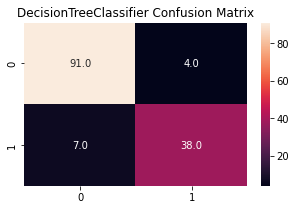

---------------------
Classification Report
---------------------
              precision    recall  f1-score   support

           2       0.93      0.96      0.94        95
           4       0.90      0.84      0.87        45

    accuracy                           0.92       140
   macro avg       0.92      0.90      0.91       140
weighted avg       0.92      0.92      0.92       140



In [50]:
# now we know the best parameters with GridSearchCV
# Analysis the model

print("========================")
print("[DecisionTreeClassifier]")
print("========================")

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

scaler = grid_accuracy[grid_accuracy['model'] == 'DecisionTreeClassifier'].scaler
scaler = scaler.array[0]
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

parm = grid_accuracy[grid_accuracy['model'] == 'DecisionTreeClassifier'].parm
parm_dic = parm.array[0]

DT = DecisionTreeClassifier(criterion=parm_dic['criterion'], max_depth=parm_dic['max_depth'],
                            splitter=parm_dic['splitter'], random_state=42);
DT.fit(X_train, y_train)
y_pred = DT.predict(X_test)

print("------------------------")
print("parameters")
print("------------------------")
print(DT.get_params())
print()

print("------------------------")
print("Accuracy")
print("------------------------")
print("Accuracy score (training) : %0.6f" % DT.score(X_train, y_train))
print("Accuracy score (testing) : %0.6f" % DT.score(X_test, y_test))  # same score -> accuracy_score(y_test, y_pred)

dt_cf = confusion_matrix(y_test, y_pred)
dt_mat = pd.DataFrame(dt_cf)
plt.figure(figsize=(5, 3))
plt.title('DecisionTreeClassifier Confusion Matrix')
sns.heatmap(dt_mat, annot=True, fmt='.1f')
plt.show()

print("---------------------")
print("Classification Report")
print("---------------------")
print(classification_report(y_test, y_pred))

[LogisticRegression]
------------------------
parameters
------------------------
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 50, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

------------------------
Accuracy
------------------------
Accuracy score (training) : 0.969589
Accuracy score (testing) : 0.971429


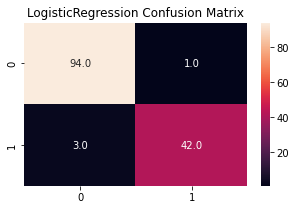

---------------------
Classification Report
---------------------
              precision    recall  f1-score   support

           2       0.97      0.99      0.98        95
           4       0.98      0.93      0.95        45

    accuracy                           0.97       140
   macro avg       0.97      0.96      0.97       140
weighted avg       0.97      0.97      0.97       140



In [51]:
print("========================")
print("[LogisticRegression]")
print("========================")

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

scaler = grid_accuracy[grid_accuracy['model'] == 'LogisticRegression'].scaler
scaler = scaler.array[0]
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

parm = grid_accuracy[grid_accuracy['model'] == 'LogisticRegression'].parm
parm_dic = parm.array[0]

LG = LogisticRegression(max_iter=parm_dic['max_iter'], solver=parm_dic['solver'], random_state=42);
LG.fit(X_train, y_train)
y_pred = LG.predict(X_test)

print("------------------------")
print("parameters")
print("------------------------")
print(LG.get_params())
print()

print("------------------------")
print("Accuracy")
print("------------------------")
print("Accuracy score (training) : %0.6f" % LG.score(X_train, y_train))
print("Accuracy score (testing) : %0.6f" % LG.score(X_test, y_test))  # same score -> accuracy_score(y_test, y_pred)

lg_cf = confusion_matrix(y_test, y_pred)
lg_cf_mat = pd.DataFrame(lg_cf)
plt.figure(figsize=(5, 3))
plt.title('LogisticRegression Confusion Matrix')
sns.heatmap(lg_cf_mat, annot=True, fmt='.1f')
plt.show()

print("---------------------")
print("Classification Report")
print("---------------------")
print(classification_report(y_test, y_pred))

[SVM]
------------------------
parameters
------------------------
{'C': 0.1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.3, 'kernel': 'sigmoid', 'max_iter': 50, 'probability': False, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}

------------------------
Accuracy
------------------------
Accuracy score (training) : 0.973166
Accuracy score (testing) : 0.978571


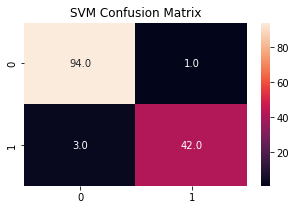

---------------------
Classification Report
---------------------
              precision    recall  f1-score   support

           2       0.99      0.98      0.98        95
           4       0.96      0.98      0.97        45

    accuracy                           0.98       140
   macro avg       0.97      0.98      0.98       140
weighted avg       0.98      0.98      0.98       140



In [52]:
print("========================")
print("[SVM]")
print("========================")

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

scaler = grid_accuracy[grid_accuracy['model'] == 'SVM'].scaler
scaler = scaler.array[0]
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

parm = grid_accuracy[grid_accuracy['model'] == 'SVM'].parm
parm_dic = parm.array[0]

SVM = svm.SVC(C=parm_dic['C'], gamma=parm_dic['gamma'], kernel=parm_dic['kernel'],
                        max_iter=parm_dic['max_iter'], random_state=42);
SVM.fit(X_train, y_train)
y_pred = SVM.predict(X_test)

print("------------------------")
print("parameters")
print("------------------------")
print(SVM.get_params())
print()

print("------------------------")
print("Accuracy")
print("------------------------")
print("Accuracy score (training) : %0.6f" % SVM.score(X_train, y_train))
print("Accuracy score (testing) : %0.6f" % SVM.score(X_test, y_test))  # same score -> accuracy_score(y_test, y_pred)

svm_cf = confusion_matrix(y_test, y_pred)
svm_cf_mat = pd.DataFrame(lg_cf)
plt.figure(figsize=(5, 3))
plt.title('SVM Confusion Matrix')
sns.heatmap(svm_cf_mat, annot=True, fmt='.1f')
plt.show()

print("---------------------")
print("Classification Report")
print("---------------------")
print(classification_report(y_test, y_pred))